In [ ]:
import json
import re
import numpy as np
import pandas as pd
import random
import collections
from collections import defaultdict
from scipy.spatial.distance import pdist,squareform
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import itertools
from sklearn.utils import murmurhash3_32
from itertools import combinations
import hashlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
np.random.seed(10)


In [ ]:
with open('TVs-all-merged.json') as f:
    data = json.load(f)

total_inputs = sum(len(model_entries) for model_entries in data.values())
print(total_inputs)

dataframe=pd.DataFrame()

1624


In [ ]:
for code, products in data.items():
    for product in products:
        model_ID = product["modelID"]
        dataframe = pd.concat([dataframe, pd.DataFrame([product])], ignore_index=True)

# Delete the url
if 'url' in dataframe.columns:
    dataframe = dataframe.drop('url', axis=1)

print(dataframe)

def standardize_units(value):
    units = {
        "inch": [r'["”]', r'inch', r'inches', r'-inch', r' inch', r' inches'],
        "hz": [r'hz', r'hertz', r'-hz', r' hz', r' hertz'],
        "lbs": [r'pounds', r' pounds', r'lb', r'lbs.', r' lbs.', r' lbs']
    }
    for unit, forms in units.items():
        for form in forms:
            value = re.sub(form, unit, value)
    return value
def value_clean(value):

    value = value.lower()
    # Round numbers to integers
    value = re.sub(r'\b\d+\.\d+\b', lambda m: str(round(float(m.group()))), value)

    #standardize the units of measurement
    value = standardize_units(value)
    # Turn fractions into decimals
    value = re.sub(r'(\d+)-(\d+)/(\d+)', lambda m: str(float(m.group(1)) + float(m.group(2)) / float(m.group(3))), value)

    # Handle "1920 x 1080"
    value = re.sub(r'(\d+)\s*[x×X]\s*(\d+)', r'\1x\2', value)

    # Replace special characters
    special_characters = r"#!@%^&*$()_-+~`;,<>/\\|[]?-'"
    for char in special_characters:
        value = value.replace(char, " ")

    # Normalize multiple spaces
    value = value.strip()
    value = re.sub(r" +", " ", value)

    return value

def key_clean(key):
    key = key.lower()

    # Remove trailing colons
    key = re.sub(r':$', '', key)
    if 'screen size' in key:
        return 'screen size'

    #Standardize some specific expressions such as weight or width
    key = re.sub(r'product weight', 'weight', key)
    key = re.sub(r'product width', 'width', key)
    key = re.sub(r'hdmi inputs', 'hdmi', key)
    key = re.sub(r'brand name', 'brand', key)
    key = re.sub(r'screen size class', 'screen size', key)
    return key

units = {
    "inch": [r'["”]', r'inch', r'inches', r'-inch', r' inch', r' inches'],
    "hz": [r'hz', r'hertz', r'-hz', r' hz', r' hertz']
}


def title_clean(title):
    title = title.lower()
    for unit, forms in units.items():
        for form in forms:
            title = re.sub(form, unit, title)

    # Remove non-alphanumeric characters
    title = re.sub(r'[^a-z0-9\s]', '', title)
    return title


def data_cleaned(data):
    cleaned_data = data.copy()
    for index, row in cleaned_data.iterrows():
        # Clean the title
        if 'title' in row and pd.notna(row['title']):
            cleaned_data.at[index, 'title'] = title_clean(row['title'])

        # Clean the featuresMap if it exists and is a dictionary
        if 'featuresMap' in row and isinstance(row['featuresMap'], dict):
            cleaned_data.at[index, 'featuresMap'] = {
                key_clean(k): value_clean(v) for k, v in row['featuresMap'].items()
            }

    return cleaned_data

# Apply the cleaning function to the DataFrame
new_data = data_cleaned(dataframe)
new_data.to_excel("Cleaned_Products.xlsx", index=False)

             shop         modelID  \
0     bestbuy.com    29PFL4508/F7   
1      newegg.com         SC-3211   
2     bestbuy.com     LC-90LE657U   
3     bestbuy.com    39PFL2908/F7   
4      newegg.com      LC70LE550U   
...           ...             ...   
1619  bestbuy.com      TC-P55GT31   
1620  bestbuy.com  UN40EH5000FXZA   
1621   newegg.com  UN40EH5000FXZA   
1622  bestbuy.com    NS-32E859A11   
1623  bestbuy.com            E424   

                                            featuresMap  \
0     {'Screen Size Class': '29"', 'DVI Inputs': '0'...   
1     {'Headphone': 'Yes', 'Remote Control': 'Full F...   
2     {'Language Options': 'English, French, Spanish...   
3     {'Meta Title': 'Philips Electronics 39PFL2908'...   
4     {'Remote Control': 'Yes', 'Series': 'Aquos', '...   
...                                                 ...   
1619  {'Internet Connectable': 'Yes', 'Language Opti...   
1620  {'Screen Size Class': '40"', 'DVI Inputs': '0'...   
1621  {'Component Video'

In [ ]:
#Model Words
titles=new_data["title"]
print(titles[:10])
keys_values=new_data['featuresMap']
print(keys_values[:10])

title_mw=set()
features_mw=set()

title_pattern = r'\b[a-zA-Z]*\d+[a-zA-Z]+\b|\b\d+[a-zA-Z]*\b|\b[a-zA-Z]+\d+\b'
feature_pattern = r'\b\d+[a-zA-Z]+\b|\b[a-zA-Z]+\d+\b'


# Extract model words for the current titles
for title in titles:
    title_model_words = re.findall(title_pattern, title)
    title_mw.update(title_model_words)

# Extract model words from feature key-value pairs
for feature in keys_values:
    if isinstance(feature, dict):
        for key, value in feature.items():
            # Find the model words in the values
            feature_model_words_value = re.findall(feature_pattern, str(value))  # Convert value to string

            # Add the model words to the set
            features_mw.update(feature_model_words_value)

model_words = list(title_mw.union(features_mw))

model_words = sorted(model_words)

model_words_df = pd.DataFrame(model_words, columns=["Model Words"])

# Save the DataFrame to an Excel file
model_words_df.to_excel("sorted_model_words.xlsx", index=False)
print("First Title Model Words:", list(title_mw)[:10])
print("First Feature Model Words:", list(features_mw)[:10])

print(len(title_mw))
print(len(features_mw))

0    philips 4000 series 29inch class 2812inch diag...
1    neweggcom  supersonic 32inch 720p led hdtv sc3211
2    sharp aquos 90inch class 90inch diag led 1080p...
3    philips 2000 series 39inch class 3858inch diag...
4    neweggcom  sharp aquos 70inch class 695inch di...
5    neweggcom  refurbished samsung 40inch 1080p 12...
6    samsung 40inch class 40inch diag ledlcd tv 108...
7    samsung 46inch class 46inch diag ledlcd tv 108...
8    nec refurbished 46inch class 46inch diag ledlc...
9    samsung un46es6580 46inch 1080p 120hz 3d slim ...
Name: title, dtype: object
0    {'screen size': '28.5inch', 'dvi inputs': '0',...
1    {'headphone': 'yes', 'remote control': 'full f...
2    {'language options': 'english french spanish',...
3    {'meta title': 'philips electronics 39pfl2908'...
4    {'remote control': 'yes', 'series': 'aquos', '...
5    {'component video': '1 in', 'lan': '1', 'recom...
6    {'meta title': 'samsung hg40na577lf', 'energy ...
7    {'meta title': 'samsung un46f5000

In [ ]:
## Binary Matrix Construction Function
import pandas as pd


# Function to create binary vector for each product
def create_binary_vector(title, features, modelwords):
    # Initialize binary vector with 0s
    binary_vector = [0] * (len(modelwords))

    for i, word in enumerate(modelwords):
        if word in title.lower():
            binary_vector[i]=1
        for value in features.values():
            if word in value.lower():
                binary_vector[i]=1

    return binary_vector

In [ ]:
def create_binary_matrix(titles, keys_values, model_words):
  binary_matrix = []

  # Loop through the titles and corresponding feature maps
  for i in range(len(titles)):
        title = titles[i]
        features = keys_values[i]

        # Generate the binary vector for the current product
        binary_vector = create_binary_vector(title, features, model_words)

        # Append the binary vector to the binary matrix
        binary_matrix.append(binary_vector)

  # Create a DataFrame from the binary matrix
  binary_vectors_df = pd.DataFrame(binary_matrix, columns=model_words)

    # Transpose and convert to numpy array
  binary_matrix_transposed = binary_vectors_df.transpose().to_numpy()

  return binary_matrix_transposed

binary_matrix = create_binary_matrix(titles, keys_values, model_words)
print(binary_matrix.shape)

(1013, 1624)


In [ ]:


def construct_signature_matrix(binary_matrix, num_permutations):
    n_rows, n_columns = binary_matrix.shape

    # Create the signature matrix with infinity elements
    signature_matrix = np.full((num_permutations, n_columns), np.inf)

    # Generate random permutations
    for i in range(num_permutations):
        permutation = np.random.permutation(n_rows)

        # Compute the signature for each column, stopping the first time we encounter 1
        for col_index in range(n_columns):
            for row_index in permutation:
                if binary_matrix[row_index, col_index] == 1:
                    signature_matrix[i, col_index] = row_index
                    break

    return signature_matrix

num_permutations = 300

signature_matrix = construct_signature_matrix(binary_matrix, num_permutations)

# Convert signature matrix to DataFrame
signature_df = pd.DataFrame(signature_matrix)

# Save signature matrix to an Excel file
signature_df.to_excel("signature_matrix.xlsx", index=False)
print(signature_matrix.shape)

(300, 1624)


In [ ]:
def locality_sensitive_hashing(signature_matrix, num_bands, num_buckets):

    n_rows, n_columns = signature_matrix.shape
    rows_per_band = n_rows // num_bands

    if n_rows % num_bands != 0:
        raise ValueError("The number of rows in the signature matrix must be divisible by the number of bands.")

    # Create an empty set of candidate pairs
    candidates = set()

    # Process each band separately
    for i in range(num_bands):
        start_row = i * rows_per_band
        end_row = start_row + rows_per_band

        # Create a hash table for the current band
        hash_table = defaultdict(list)

        #For every single product extract its corresponding band
        for col_index in range(n_columns):

            band = tuple(signature_matrix[start_row:end_row, col_index])

            # Hash the band into one of the buckets
            band_hash_value = murmurhash3_32(str(band), seed=42) % num_buckets

            # Add column index (product) to the bucket
            hash_table[band_hash_value].append(col_index)

        #Extract every possible combination of two products that belong to the same bucket
        for bucket in hash_table.values():
            if len(bucket) > 1:
                for pair in combinations(bucket, 2):
                    candidates.add(pair)

    candidates=sorted(candidates)
    return candidates



In [ ]:
def duplicates_modelID(data):
    grouped = data.groupby('modelID')

    pairs = []

    # Generate all possible pairs of products with the same modelID
    for model_id, group in grouped:
        if len(group) > 1:

            pairs.extend(combinations(group.index, 2))

    pairs=sorted(pairs)

    return pairs

def validate_duplicates(data, candidate_pairs):
    #find the candidate pairs that have the same modelID and are thus true pairs
    true_pairs = []
    for index1, index2 in candidate_pairs:
        if data.at[index1, 'modelID'] == data.at[index2, 'modelID']:
            true_pairs.append((index1, index2))
    return true_pairs



In [ ]:
def calculate_metrics(true_pairs, predicted_pairs, total_products):

    # Calculate TP, FP, FN
    TP = len(true_pairs & predicted_pairs)
    FP = len(predicted_pairs - true_pairs)
    FN = len(true_pairs - predicted_pairs)

    # Total possible pairs all possible unique pairs in the dataset
    total_pairs = (total_products * (total_products - 1)) // 2

    # TN
    TN = total_pairs - TP - FP - FN

    # Precision, Recall, F1-Score
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    PC=TP/len(true_pairs)
    PQ=TP/len(predicted_pairs)
    F1star=(2*PQ*PC)/(PQ+PC)
    return {
        "TP": TP,
        "FP": FP,
        "TN": TN,
        "FN": FN,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score,
        "PQ":PQ,
        "PC":PC,
        "F1star":F1star
    }


In [ ]:
#write down all the different brands found in the dataset
brand_names = [
    "samsung", "lg", "panasonic", "toshiba", "sony", "sharp", "vizio", "insignia",
    "philips", "coby", "rca", "dynex", "nec", "sansui", "haier", "westinghouse",
    "sunbritetv", "tcl", "magnavox", "jvc", "supersonic", "naxa", "viewsonic",
    "sceptre", "sanyo", "hisense", "pyle", "mitsubishi", "seiki", "hannspree",
    "affinity", "elite", "avue", "optoma", "hiteker", "proscan", "epson", "hp",
    "viore","azend","contex","venturer","supersonic","curtisyoung","compaq","elo",
    "sony","gpx","toshiba"
]

def candidate_filtering(data, candidates, brands):
    # Search the brand names in the titles of the candidates
    brand_map = {}
    for index, row in data.iterrows():
        title = row['title'].lower()
        for brand in brands:
            if brand in title:
                brand_map[index] = brand
                #Once we find a brand we stop searching
                break

    # Filter candidates, keeping the ones with the same brand
    filtered_candidates = [
        candidate for candidate in candidates
        if brand_map.get(candidate[0]) == brand_map.get(candidate[1])
    ]

    return filtered_candidates

In [ ]:
def jaccard_similarity_binary(vector1, vector2):
    #jaccard similarity between two vectors
    # Intersection is the count of positions where both vectors are 1
    intersection = np.sum(np.logical_and(vector1, vector2))

    # Union is the count of positions where at least one of the vectors is 1
    union = np.sum(np.logical_or(vector1, vector2))

    if union == 0:
        return 0.0
    return intersection / union

def jaccard_similarity_title(pair, data):
    #jaccard similarity of the titles
    product1, product2 = pair

    # Extract tokens from the titles
    tokens1 = set(data.at[product1, "title"].lower().split())
    tokens2 = set(data.at[product2, "title"].lower().split())

    #Intersection and union
    intersection = len(tokens1 & tokens2)
    union = len(tokens1 | tokens2)

    if union == 0:
        return 0.0

    return intersection / union

def dissimilarity_matrix(data, binary_matrix,filtered_candidates):
    n_products = data.shape[0]
    #Introduce a dissimilarity matrix with infinite elements
    dissimilarity_matrix = np.full((n_products, n_products), np.inf)

    # Calculate similarity values for filtered candidates
    for candidate in filtered_candidates:
        product1, product2 = candidate
        title_similarity = jaccard_similarity_title(candidate, data)
        binary_similarity = jaccard_similarity_binary(binary_matrix[:,product1], binary_matrix[:,product2])
        similarity = 0.5*title_similarity + 0.5*binary_similarity
        #Calculate the dissimilarity
        dissimilarity = 1 - similarity
        dissimilarity_matrix[product1, product2] = dissimilarity
        dissimilarity_matrix[product2, product1] = dissimilarity

    # Fill the diagonal with zeros
    np.fill_diagonal(dissimilarity_matrix, 0)
    return dissimilarity_matrix



In [ ]:
def initial_clustering(dissimilarity_matrix, threshold):

    n_products = dissimilarity_matrix.shape[0]
    clusters = []
    estimated_pairs = []
    assigned = set()

    for i in range(n_products):
        #skip the products that have already been assigned to a cluster
        if i in assigned:
            continue

        # Create a new cluster
        new_cluster = [i]
        assigned.add(i)

        #Scan products with index > i
        for j in range(i + 1, n_products):
            if j in assigned:
                continue

            #find the first product with a dissimilarity smaller than the threshold
            if dissimilarity_matrix[i, j] < threshold:
                new_cluster.append(j)
                assigned.add(j)
                #add id to the same cluster and break
                estimated_pairs.append((i, j))
                break
        # Add the cluster to the list of clusters
        clusters.append(new_cluster)

    return  estimated_pairs,clusters


In [ ]:

def final_clustering(dissimilarity_matrix, initial_clusters, threshold):
    final_clusters = []
    final_pairs = []

    for cluster in initial_clusters:
        if len(cluster) > 1:
            #Create a sub-dissimilarity matrix for the current cluster
            sub_dissimilarity_matrix = dissimilarity_matrix[np.ix_(cluster, cluster)]

            #Carry out secondary clustering using complete linkage
            medoid_clustering = AgglomerativeClustering(
                n_clusters=None,
                metric='precomputed',
                linkage='complete',
                distance_threshold=threshold
            )
            labels = medoid_clustering.fit_predict(sub_dissimilarity_matrix)

            # Create sub-clusters based on the secondary clustering
            sub_clusters = defaultdict(list)
            for i, label in enumerate(labels):
                sub_clusters[label].append(cluster[i])

            # Add sub-clusters to final clusters
            final_clusters.extend(sub_clusters.values())
        else:
            #If a cluster consists of a single product, append it directly
            final_clusters.append(cluster)

    # Generate all possible pairs from the final clusters
    for cluster in final_clusters:
        final_pairs.extend(combinations(cluster, 2))

    return final_clusters, final_pairs


In [ ]:
def bootstrap_evaluation(data, num_bootstraps, binary_matrix,
                         brand_names, num_bands, num_buckets):
    lsh_metrics_list = []
    msmp_metrics_list = []


    for i in range(num_bootstraps):
        print(f"Bootstrap iteration no {i + 1}")

        num_rows = int(0.63 * len(data))

        # Randomly select an index from which we can take the consecutive rows
        start_index = random.randint(0, len(data) - num_rows)

        # Select the block of consecutive rows
        train_set = data.iloc[start_index:start_index + num_rows]

        # Use the remaining data for testing
        test_set = data.drop(train_set.index)


        #Split binary matrix to match training and testing sets
        train_binary_matrix = binary_matrix[:, train_set.index]
        test_binary_matrix = binary_matrix[:, test_set.index]

        train_set=train_set.reset_index(drop=True)
        test_set=test_set.reset_index(drop=True)
        # Training phase
        candidate_pairs = locality_sensitive_hashing(
            construct_signature_matrix(train_binary_matrix, 300), num_bands, num_buckets
        )
        n_candidates=len(candidate_pairs)
        n_possible_pairs=len(train_set)*(len(train_set)-1)
        fraction_of_comparisons=n_candidates/n_possible_pairs

        train_true_pairs = duplicates_modelID(train_set)
        print(train_true_pairs)

        #Locality Sensitive Hashing on the train set
        lsh_metrics = calculate_metrics(set(train_true_pairs), set(candidate_pairs), len(train_set))
        print(f"LSH Metrics: {lsh_metrics}")
        lsh_metrics_list.append(lsh_metrics)

        #Filter the candidates based on their brand
        filtered_candidates = candidate_filtering(train_set, candidate_pairs, brand_names)
        train_dissimilarity = dissimilarity_matrix(train_set, train_binary_matrix, filtered_candidates)
        train_dissimilarity[np.isinf(train_dissimilarity)] = 10**6

        print(calculate_metrics(set(train_true_pairs), set(filtered_candidates), len(train_set)))
        # Find the best thresholds for initial final clustering based on F1 score
        best_final_threshold = 0
        best_initial_threshold=0
        f1_final = 0
        for initial_threshold in np.arange(0.8,0.95,0.05):
          initial_pairs, initial_clusters = initial_clustering(train_dissimilarity, initial_threshold)
          filtered_pairs = candidate_filtering(train_set, initial_pairs, brand_names)
          for final_threshold in np.arange(0.5, 1.0, 0.1):
            final_clusters, final_pairs = final_clustering(train_dissimilarity, initial_clusters, final_threshold )

            final_metrics = calculate_metrics(set(train_true_pairs), set(final_pairs), len(train_set))
            if final_metrics["F1-Score"] > f1_final:
                f1_final = final_metrics["F1-Score"]
                best_final_threshold = final_threshold
                best_initial_threshold = initial_threshold
        print(f"Best final threshold: {best_final_threshold}")
        print(f"Best initial threshold: {best_initial_threshold}")

        # Testing phase using the best final and initial threshold
        test_true_pairs = duplicates_modelID(test_set)

        #LSH on the test set
        test_candidate_pairs = locality_sensitive_hashing(
            construct_signature_matrix(test_binary_matrix, 300), num_bands, num_buckets
        )
        #Filter the candidates based on the brand
        test_filtered_candidates = candidate_filtering(test_set, test_candidate_pairs, brand_names)
        test_dissimilarity = dissimilarity_matrix(test_set, test_binary_matrix, test_filtered_candidates)
        test_dissimilarity[np.isinf(test_dissimilarity)] = 10**6

        initial_test_pairs, initial_test_clusters = initial_clustering(test_dissimilarity, best_initial_threshold)
        initial_test_pairs = candidate_filtering(test_set, initial_test_pairs, brand_names)
        test_final_clusters, test_final_pairs = final_clustering(test_dissimilarity, initial_test_clusters, best_final_threshold)


        # Calculate metrics for the test set
        msmp_metrics = calculate_metrics(set(test_true_pairs), set(test_final_pairs), len(test_set))
        msmp_metrics_list.append(msmp_metrics)
        print(f"MSMP Metrics: {msmp_metrics}")

    return lsh_metrics_list,msmp_metrics_list,fraction_of_comparisons



Bootstrap iteration no 1
[(0, 1), (16, 17), (19, 20), (23, 24), (25, 26), (39, 40), (41, 42), (46, 47), (52, 53), (56, 57), (62, 63), (66, 67), (66, 68), (67, 68), (69, 70), (73, 74), (77, 78), (89, 90), (94, 95), (98, 99), (100, 101), (103, 104), (107, 108), (112, 113), (117, 118), (128, 129), (130, 131), (136, 137), (138, 139), (142, 143), (142, 144), (143, 144), (148, 149), (156, 157), (158, 159), (172, 173), (177, 178), (177, 179), (178, 179), (182, 183), (182, 184), (183, 184), (186, 187), (188, 189), (191, 192), (191, 193), (192, 193), (194, 195), (201, 202), (205, 206), (213, 214), (215, 216), (222, 223), (230, 231), (232, 233), (235, 236), (235, 237), (236, 237), (243, 244), (250, 251), (256, 257), (261, 262), (276, 277), (282, 283), (286, 287), (294, 295), (302, 303), (304, 305), (310, 311), (314, 315), (321, 322), (324, 325), (331, 332), (333, 334), (342, 343), (351, 352), (355, 356), (359, 360), (363, 364), (371, 372), (385, 386), (387, 388), (387, 389), (388, 389), (391, 39

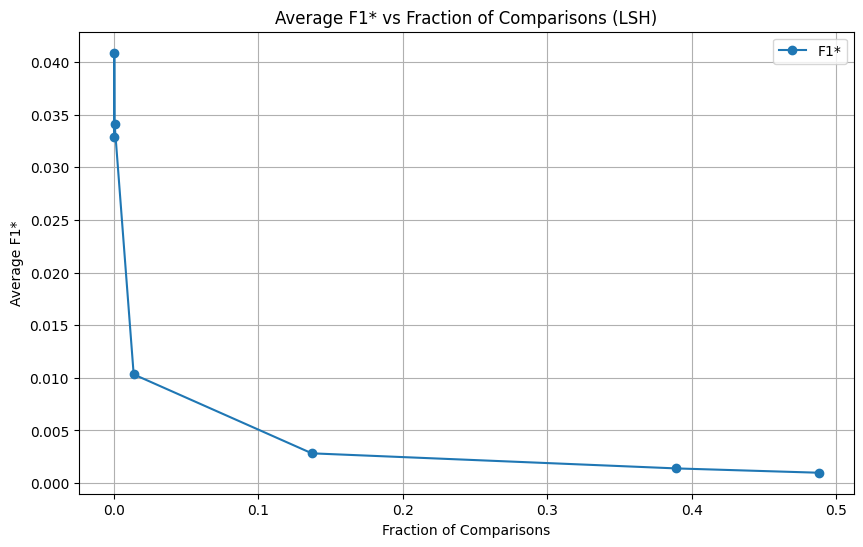

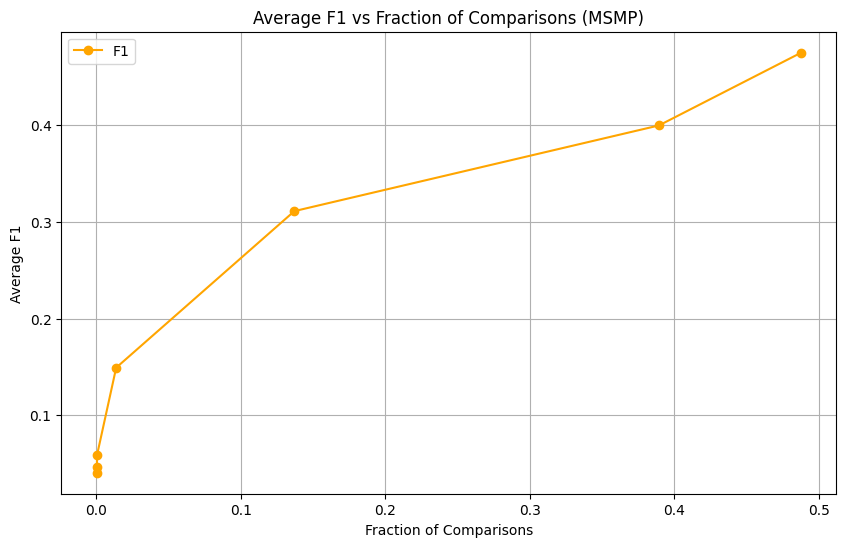

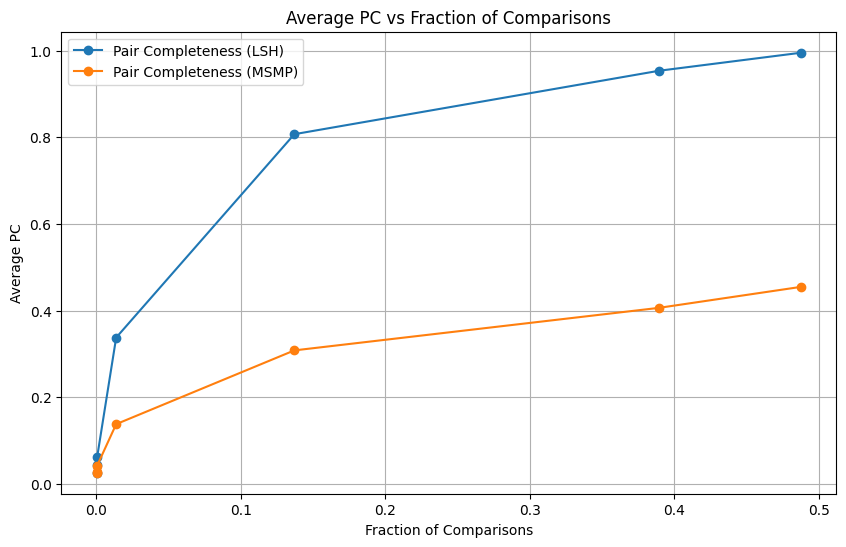

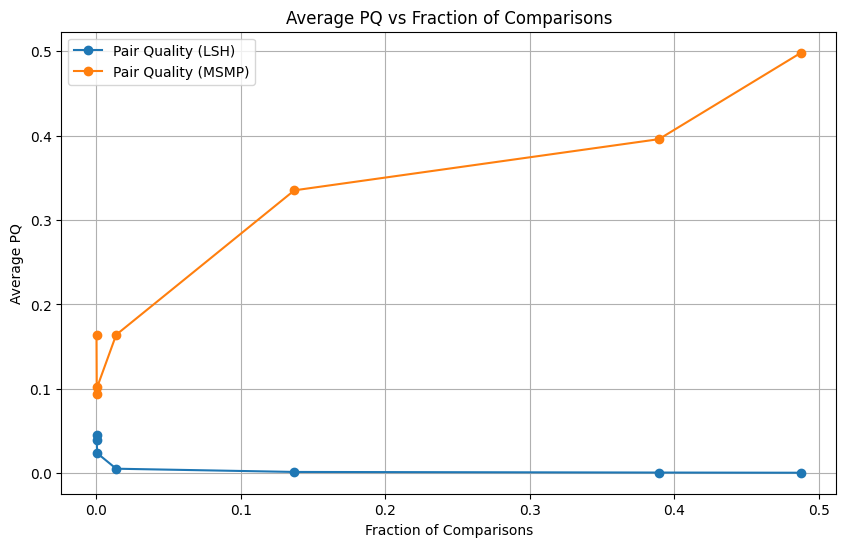

In [ ]:
# Define the lists to store the results for each metric
num_bands_list = [20, 25, 30, 50, 75, 100, 150]

f1lsh = []
f1msmp = []
pqlsh = []
pqmsmp = []
pclsh = []
pcmsmp = []

for num_bands in num_bands_list:
    r = 300 / num_bands
    t = (1 / num_bands) ** (1 / r)

    # Call the bootstrap evaluation function
    lsh_metrics, msmp_metrics, fraction = bootstrap_evaluation(new_data, 5, binary_matrix, brand_names, num_bands, 1254739)

    # Calculate the average metrics from each bootstrap
    avg_f1star_lsh = np.mean([metric['F1star'] for metric in lsh_metrics])
    avg_pq_lsh = np.mean([metric['PQ'] for metric in lsh_metrics])
    avg_pc_lsh = np.mean([metric['PC'] for metric in lsh_metrics])

    avg_f1_msmp = np.mean([metric['F1-Score'] for metric in msmp_metrics])
    avg_pq_msmp = np.mean([metric['PQ'] for metric in msmp_metrics])
    avg_pc_msmp = np.mean([metric['PC'] for metric in msmp_metrics])

    # Extract the results for the fraction of comparison and the metrics
    f1lsh.append((fraction, avg_f1star_lsh))
    f1msmp.append((fraction, avg_f1_msmp))
    pqlsh.append((fraction, avg_pq_lsh))
    pqmsmp.append((fraction, avg_pq_msmp))
    pclsh.append((fraction, avg_pc_lsh))
    pcmsmp.append((fraction, avg_pc_msmp))

# Set the fraction of comparison as x and metrics as y
fraction_f1lsh, f1star_lsh_values = zip(*f1lsh)
fraction_f1msmp, f1_msmp_values = zip(*f1msmp)
fraction_pqlsh, pq_lsh_values = zip(*pqlsh)
fraction_pqmsmp, pq_msmp_values = zip(*pqmsmp)
fraction_pclsh, pc_lsh_values = zip(*pclsh)
fraction_pcmsmp, pc_msmp_values = zip(*pcmsmp)

# Plot F1* for the LSH
plt.figure(figsize=(10, 6))
plt.plot(fraction_f1lsh, f1star_lsh_values, label="F1*", marker="o")
plt.title("Average F1* vs Fraction of Comparisons (LSH)")
plt.xlabel("Fraction of Comparisons")
plt.ylabel("Average F1*")
plt.grid()
plt.legend()
plt.show()

# Plot F1 for the MSMP
plt.figure(figsize=(10, 6))
plt.plot(fraction_f1msmp, f1_msmp_values, label="F1", color="orange", marker="o")
plt.title("Average F1 vs Fraction of Comparisons (MSMP)")
plt.xlabel("Fraction of Comparisons")
plt.ylabel("Average F1")
plt.grid()
plt.legend()
plt.show()

# Plot PC for both LSH and MSMP
plt.figure(figsize=(10, 6))
plt.plot(fraction_pclsh, pc_lsh_values, label="Pair Completeness (LSH)", marker="o")
plt.plot(fraction_pcmsmp, pc_msmp_values, label="Pair Completeness (MSMP)", marker="o")
plt.title("Average PC vs Fraction of Comparisons")
plt.xlabel("Fraction of Comparisons")
plt.ylabel("Average PC")
plt.grid()
plt.legend()
plt.show()

# Plot PQ for both LSH and MSMP
plt.figure(figsize=(10, 6))
plt.plot(fraction_pqlsh, pq_lsh_values, label="Pair Quality (LSH)", marker="o")
plt.plot(fraction_pqmsmp, pq_msmp_values, label="Pair Quality (MSMP)", marker="o")
plt.title("Average PQ vs Fraction of Comparisons")
plt.xlabel("Fraction of Comparisons")
plt.ylabel("Average PQ")
plt.grid()
plt.legend()
plt.show()
